In [142]:
import torch
import pickle
from itertools import chain
from helper.model import *
from helper.utils import *
from helper.distance_map import *
from helper.evaluate import *
from scipy import stats
from tqdm import tqdm
import pandas as pd
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

args_train_data = "uniref100_full"
#args_test_data = "price_149"
args_test_data = "new"
args_model_name = "split100_ensemble/split100_"  
args_weight_path = "uncertainty_ensemble/" 
args_N_models = 8

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
#
id_ec_train, ec_id_dict_train = get_ec_id_dict('./data/'+args_train_data+'.csv')
id_ec_test, _ = get_ec_id_dict('./data/'+args_test_data+'.csv')

In [ ]:
# keep models output embeddings
esm_embedding_train = esm_embedding(ec_id_dict_train, device, dtype)

for i in (range(args_N_models)):
    model_i = LayerNormNet(512, 128, device, dtype)
    model_name_i = args_model_name + str(i)
    print("loading model:", model_name_i)
    checkpoint = torch.load('./model/' + model_name_i + '.pth')
    model_i.load_state_dict(checkpoint)
    model_i.eval()
    emb_train_i = model_i(esm_embedding_train) 
    emb_test_i = model_embedding_test(id_ec_test, model_i, device, dtype) 
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    torch.save(emb_train_i, emb_train_i_path)
    torch.save(emb_test_i, emb_test_i_path)

In [ ]:
# get distance map for all models
eval_dist_lst = []
for i in (range(args_N_models)):
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    emb_train = torch.load(emb_train_i_path)
    emb_test = torch.load(emb_test_i_path)
    eval_dist = get_dist_map_test(
            emb_train, emb_test, ec_id_dict_train, id_ec_test, 
            device, dtype, dot=False)
    eval_dist_lst.append(eval_dist)


In [144]:
eval_dist_w_std = dict()
eval_dist_mean = dict()
# keep track of all query/ec dist std for future ranking
all_dist_std = []
# calculate distance map with standard deviation
print("calculating mean distance and std")
for query in  tqdm(eval_dist_lst[0].keys()):
    dist_mean_std = dict()
    dist_mean_dict = dict()
    # get the ec/distance dictionary
    for ec in eval_dist_lst[0][query]:
        # find distances for this query/ec pair for these models
        all_dist_per_ec = []
        for i in range(args_N_models):
            all_ec_dist_per_query = eval_dist_lst[i][query] 
            dist_i = all_ec_dist_per_query[ec]
            all_dist_per_ec.append(dist_i)
        dist_mean = np.mean(all_dist_per_ec)
        dist_std = np.std(all_dist_per_ec)
        all_dist_std.append(dist_std)
        dist_mean_std[ec] = (dist_mean, dist_std)
        dist_mean_dict[ec] = dist_mean
    eval_dist_w_std[query] = dist_mean_std
    eval_dist_mean[query] = dist_mean_dict


calculating mean distance and std


100%|██████████| 392/392 [00:56<00:00,  6.95it/s]


In [145]:
# get max sep prediction results for all models
certainty_from_all_dist_lst = []
certainty_from_dist_in_pred_lst = []
all_std_in_pred_lst = []
dist_map_df = pd.DataFrame.from_dict(eval_dist_mean); 
first_grad=True; use_max_grad=False
# get predictions
query_prediction_lst = []
for query in tqdm(dist_map_df.columns):
    smallest_10_dist_df = dist_map_df[query].nsmallest(10)
    dist_lst = list(smallest_10_dist_df)
    max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
    predictions = []
    for i in range(max_sep_i+1):
        EC_i = smallest_10_dist_df.index[i]
        dist_i = smallest_10_dist_df[i]
        predictions.append((EC_i, dist_i))
        _, dist_std = eval_dist_w_std[query][EC_i]
        # keep track of all dist std appeared in prediction
        all_std_in_pred_lst.append(dist_std)
        #print(query, EC_i, dist_std, perc_certainty)
    query_prediction_lst.append((query, predictions))

100%|██████████| 392/392 [00:00<00:00, 3563.59it/s]


In [ ]:
# subset queries into bins by certainty
args_N_bins = 8
bins_query_by_certainty = [[] for i in range(args_N_bins)]
#
query_count = 0
for query in tqdm(dist_map_df.columns):
    smallest_10_dist_df = dist_map_df[query].nsmallest(10)
    dist_lst = list(smallest_10_dist_df)
    max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
    # bin by minimum certainty
    certainty_per_query = []
    for i in range(max_sep_i+1):
        EC_i = smallest_10_dist_df.index[i]
        dist_i = smallest_10_dist_df[i]
        predictions.append((EC_i, dist_i))
        _, dist_std = eval_dist_w_std[query][EC_i]
        # certainty by all distance std in distance map
        perc_certainty = 1 - stats.percentileofscore(
            all_dist_std, dist_std, 'rank')/100
        certainty_from_all_dist_lst.append(perc_certainty)
        # certainty by all distance std in prediction
        perc_certainty_in_pred = 1 - stats.percentileofscore(
            all_std_in_pred_lst, dist_std, 'rank')/100
        certainty_from_dist_in_pred_lst.append(perc_certainty_in_pred)
        ###################################
        #certainty_per_query.append(perc_certainty) # perc method 1)
        certainty_per_query.append(perc_certainty_in_pred) # perc method 2)
    min_certainty_query = min(certainty_per_query)
    for bin_i in range(args_N_bins):
        lower, upper = bin_i/args_N_bins, (bin_i+1)/args_N_bins
        if min_certainty_query >= lower and min_certainty_query < upper:
            bins_query_by_certainty[bin_i].append(query_count)
            #print("bin_i:", bin_i)
    query_count += 1

In [160]:
# make bins cumulative
cumulative_bins = [[] for i in range(args_N_bins)]
for i in range(len(bins_query_by_certainty)):
    for ii in range(i+1):
        cumulative_bins[i] += bins_query_by_certainty[ii]

In [161]:
# write the top 10 closest EC to _top10.csv
out_filename = './eval/' + args_test_data
# _ = write_top10_choices(eval_df, out_filename)
# maximum separation results
write_max_sep_choices(dist_map_df, out_filename, first_grad=True, use_max_grad=False)
# get preds and true labels
pred_label = get_pred_labels(out_filename, pred_type='_maxsep')
pred_probs = get_pred_probs(out_filename, pred_type='_maxsep')
true_label, all_label = get_true_labels('./data/'+args_test_data)

results_per_bin = []
for bin_i in range(args_N_bins):
    query_bin = cumulative_bins[bin_i]
    pred_label_i = [pred_label[i] for i in query_bin]
    pred_probs_i = [pred_probs[i] for i in query_bin]
    true_label_i = [true_label[i] for i in query_bin]
    all_label_i = set(list(chain.from_iterable(true_label_i)))
    # print(pred_label_i, pred_probs_i, true_label_i)
    # raise
    if (len(query_bin) == 0):
        pre = 0
    else:
        pre, rec, f1, roc, acc = get_eval_metrics_new(
            pred_label_i, pred_probs_i, true_label_i, all_label_i)
    results_per_bin.append(pre)
    print("bin", bin_i, pre)

bin 0 0.43617021276595747
bin 1 0.4249249249249249
bin 2 0.42781316348195325
bin 3 0.4419265167996132
bin 4 0.46718811491538764
bin 5 0.4576519423558897
bin 6 0.4848388380421807
bin 7 0.5132367227257738
bin 8 0.5539979068550498
bin 9 0.5791165704187573


Text(0, 0.5, 'cumulative precision')

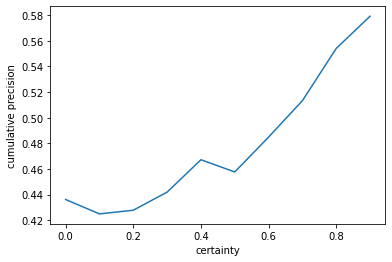

In [162]:
from matplotlib import pyplot as plt
import numpy as np
# Creating dataset
results = np.array(results_per_bin)
plt.plot([i/args_N_bins for i in range(args_N_bins)], results)
plt.xlabel("certainty")
plt.ylabel("cumulative precision")

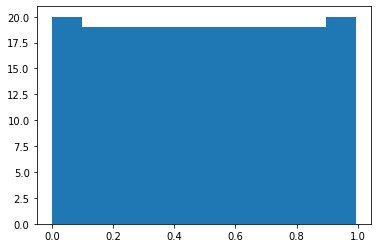

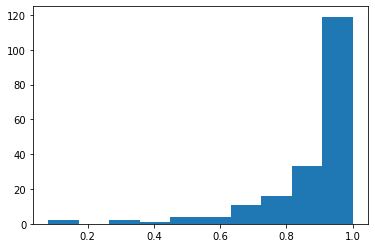

In [53]:
from matplotlib import pyplot as plt
import numpy as np
# Creating dataset
a = np.array(certainty_from_all_dist_lst)
b = np.array(certainty_from_dist_in_pred_lst)
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a)
# Show plot
plt.show()
fig, ax = plt.subplots()
ax.hist(b)
# Show plot
plt.show()